# Classification of stars

**Задача:**
- Найти данные, на которых интересно будет решать задачу классификации.
- Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).
- Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
- Используя подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания для библиотечных реализаций (например, из sklearn) четырёх методов классификации.
- Сравнить все обученные модели, построить их confusion matrices. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- (Дополнительно) Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров. Повторить все пункты задания для собственной реализации.

Задача классификации будет решаться на этом датасете: https://www.kaggle.com/datasets/deepu1109/star-dataset?resource=download

**Описание датасета:**

This CSV file contains a dataset of 240 stars of 6 classes:

Brown Dwarf -> Star Type = 0

Red Dwarf -> Star Type = 1

White Dwarf-> Star Type = 2

Main Sequence -> Star Type = 3

Supergiant -> Star Type = 4

Hypergiant -> Star Type = 5

The Luminosity and radius of each star is calculated w.r.t. that of the values of Sun.
Lo = 3.828 x 10^26 Watts
Ro = 6.9551 x 10^8 m

## 1. Загрузка данных и первичная проверка

Загрузим набор данных о классификации звёзд. Проверим структуру данных, их типы и наличие пропущенных значений, а также выведем первые строки для предварительного анализа. Это поможет понять, какие столбцы доступны, и есть ли проблемы с данными.

In [2]:
import pandas as pd
from IPython.display import display

data = pd.read_csv("star_classification.csv")  

display(data.head())  
display(data.info())  
display(data.describe())  

display(data.isnull().sum())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


None

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

Видим, что:
1. Данные состоят из 240 записей и 7 столбцов, включая как числовые, так и категориальные признаки.
2. Пропущенные значения отсутствуют, поэтому очистки данных не требуется.
3. Числовые признаки имеют значительный разброс:
   - Температура звёзд варьируется от 1939 K до 40,000 K.
   - Светимость и радиус звёзд имеют широкий диапазон значений, что, вероятно, связано с различиями между классами звёзд.
   - Абсолютная звёздная величина также охватывает большой диапазон от -11.92 до 20.06.
4. Целевой признак (`Star type`) представлен шестью классами (от 0 до 5).
5. Категориальные признаки (`Star color` и `Spectral Class`) содержат текстовые данные, которые в дальнейшем потребуется преобразовать в числовой формат.

Проверим данные на наличие дубликатов:

In [3]:
duplicates = data.duplicated().sum()
if duplicates > 0:
    data = data.drop_duplicates()
    display(f"Обнаружено и удалено {duplicates} дубликатов.")
else:
    display("Дубликаты отсутствуют.")

'Дубликаты отсутствуют.'

Данные хорошо структурированы и подготовлены для дальнейшего анализа и построения моделей классификации.

## 2. Разведочный анализ (EDA)

Визуализируем данные, чтобы получить больше информации о распределении признаков, их взаимосвязи и влиянии на целевую переменную (Star type). Это поможет сделать выводы, полезные для дальнейшей классификации.

1. Построим гистограммы для числовых признаков, чтобы понять их распределение.
2. Построим диаграммы рассеяния (scatter plots) для анализа взаимосвязи между числовыми признаками.
3. Проанализируем категориальные признаки `Star color` и `Spectral Class`, чтобы понять их влияние на целевую переменную `Star type`.

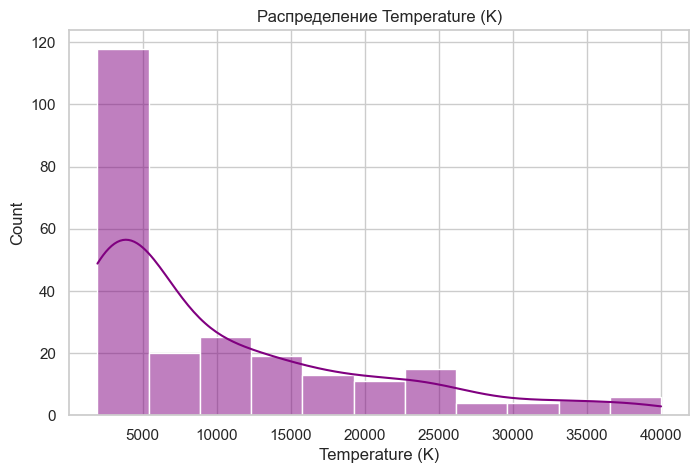

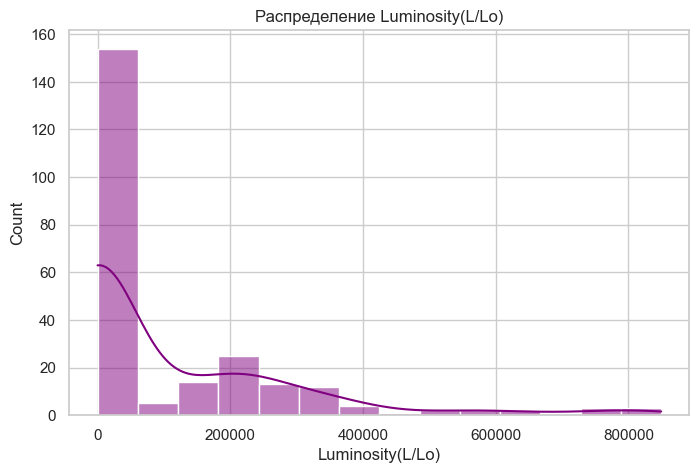

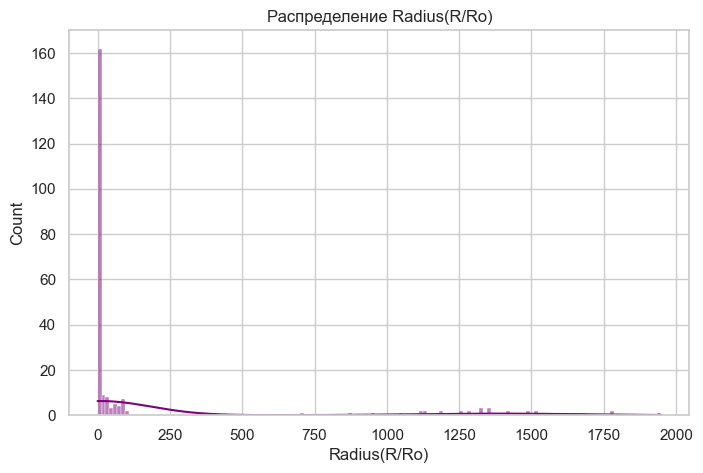

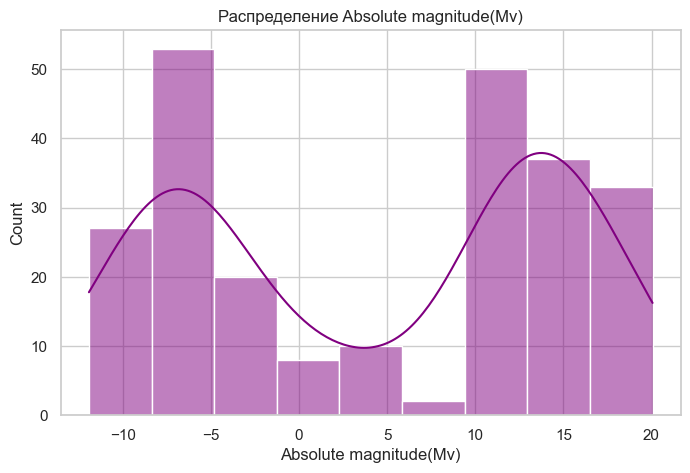

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

numerical_features = ["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)", "Absolute magnitude(Mv)"]

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[feature], kde=True, color='purple')
    plt.title(f"Распределение {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

**Распределение числовых признаков:**
   - `Temperature (K)`: Наблюдается сильная концентрация данных в области низких температур с небольшим количеством горячих звёзд.
   - `Luminosity(L/Lo)` и `Radius(R/Ro)`: Очень широкий диапазон значений с явными выбросами. Эти признаки могут потребовать нормализации.
   - `Absolute magnitude(Mv)`: Концентрация значений в нескольких диапазонах, нет явных выбросов.

<Figure size 1000x800 with 0 Axes>

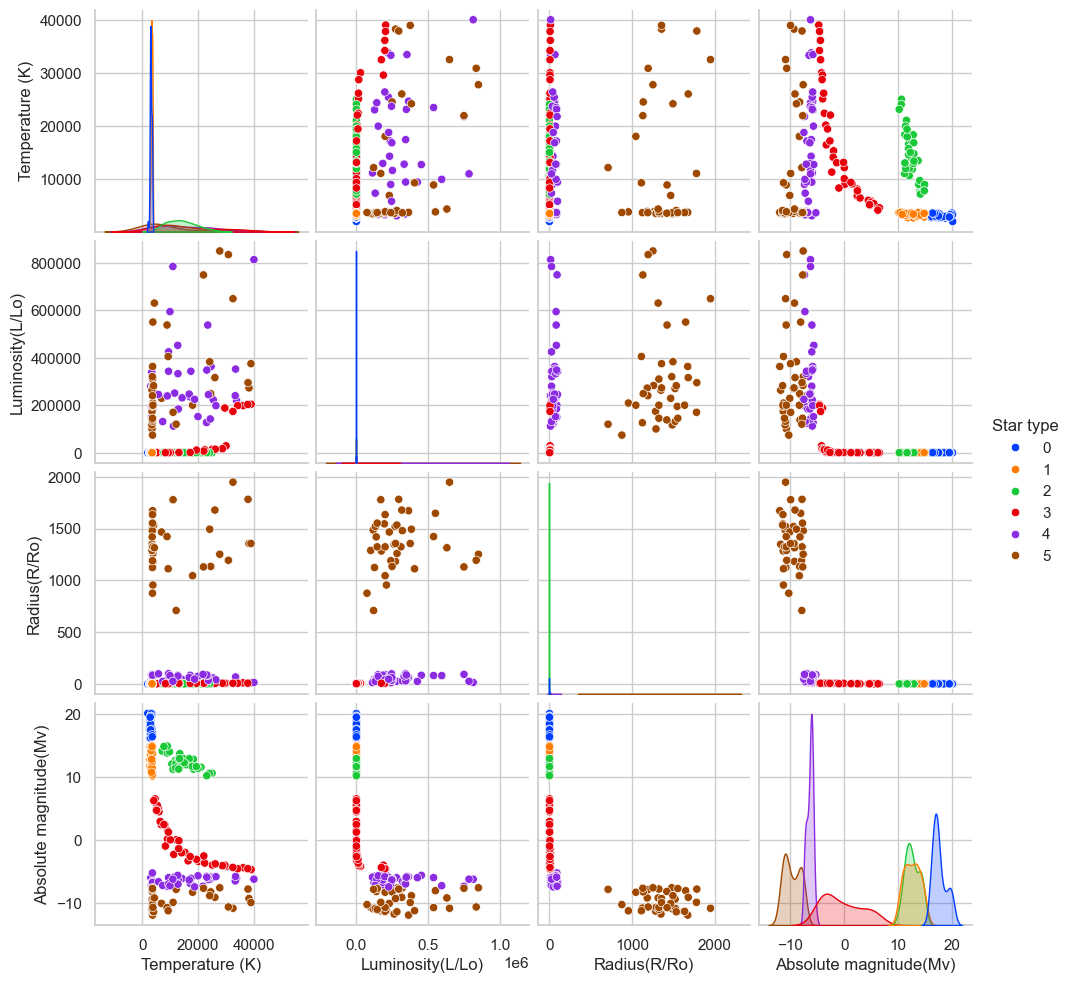

In [5]:
plt.figure(figsize=(10, 8))
sns.pairplot(data, vars=numerical_features, hue="Star type", palette="bright")
plt.show()

**Диаграммы рассеяния:**
   - Числовые признаки имеют различия между классами `Star type`. Видно, где классы визуально разделяются лучше всего.

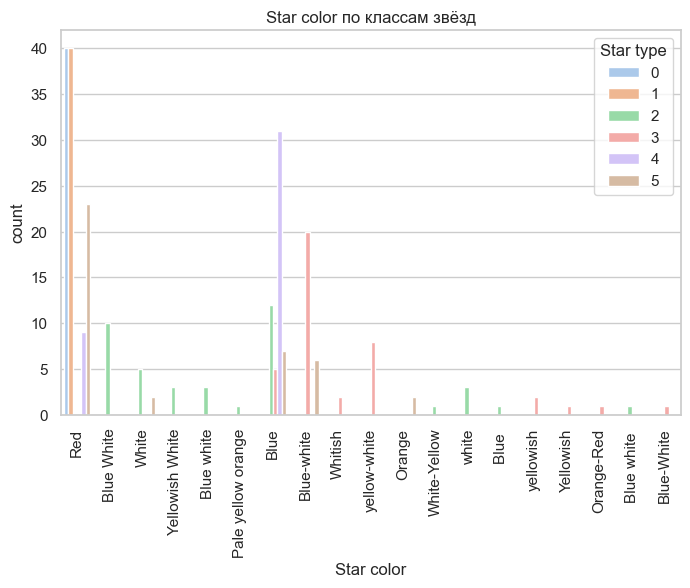

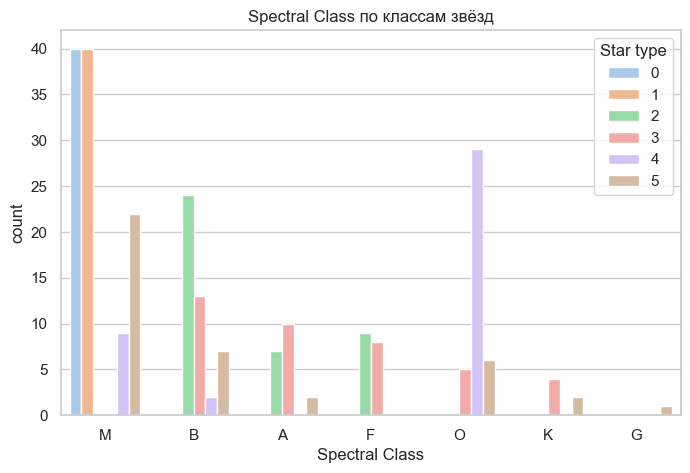

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x="Star color", hue="Star type", data=data, palette="pastel")
plt.title("Star color по классам звёзд")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x="Spectral Class", hue="Star type", data=data, palette="pastel")
plt.title("Spectral Class по классам звёзд")
plt.show()

**Категориальные признаки:**
   - `Star color`: Некоторые цвета более характерны для определённых типов звёзд, например, красные звёзды (0 класс).
   - `Spectral Class`: Классы имеют различия, связанные с типами звёзд, что может быть полезным для классификации.

## 3. Преобразование данных (Feature Engineering)

На основе предварительного анализа проведём следующие действия:
1. Преобразуем категориальные признаки `Star color` и `Spectral Class` в количественные.
2. Проверим данные на выбросы и решим, как с ними поступить.

В данном случае удаление лишних данных не требуется, так как все признаки могут быть полезны. Новые признаки на основе имеющихся создавать не будем, так как они, скорее всего, будут высоко коррелированы между собой, что не добавит существенного вклада в модель.

In [7]:
from sklearn.preprocessing import LabelEncoder

le_star_color = LabelEncoder()
le_spectral_class = LabelEncoder()

data['Star color'] = le_star_color.fit_transform(data['Star color'])
data['Spectral Class'] = le_spectral_class.fit_transform(data['Spectral Class'])

display(data.head())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,10,5
1,3042,0.000500,0.1542,16.60,0,10,5
2,2600,0.000300,0.1020,18.70,0,10,5
3,2800,0.000200,0.1600,16.65,0,10,5
4,1939,0.000138,0.1030,20.06,0,10,5


Преобразование категориальных признаков: признаки `Star color` и `Spectral Class` были преобразованы в числовую форму с помощью метода Label Encoding. Данные теперь готовы для дальнейшего анализа и моделирования.

Визуализируем выбросы в признаках Luminosity(L/Lo) и Radius(R/Ro), которые мы заметили на гистограммах.

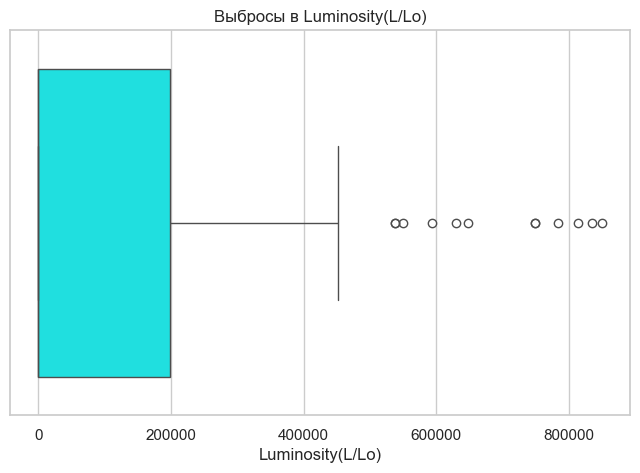

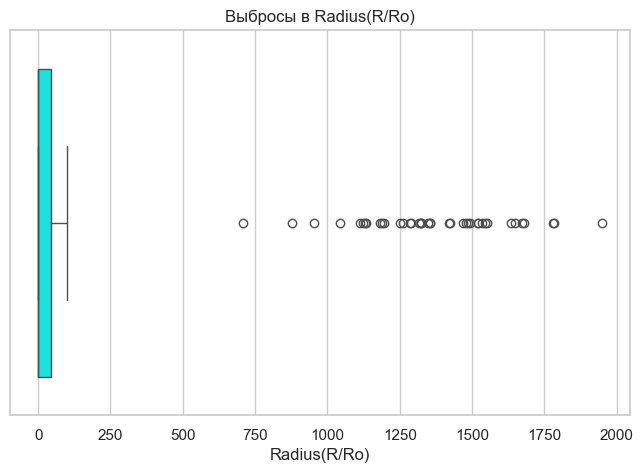

In [9]:
numerical_features = ["Luminosity(L/Lo)", "Radius(R/Ro)"]

for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data[feature], color='cyan')
    plt.title(f"Выбросы в {feature}")
    plt.show()

Выбросы в этих данных можно объяснить особенностями характеристик звёзд, это не ошибки, а просто природные колебания, свойственные данным. Удалять или сильно изменять их не будем, так как это может привести к потере информации, которая может быть важной для правильного предсказания. Поэтому, для уменьшения влияния крупных выбросов, **стандартизируем данные** (кроме целевого признака Star type). Это поможет привести все признаки к одному масштабу и уменьшить влияние экстремальных значений.

In [10]:
from sklearn.preprocessing import StandardScaler

features = data.drop(columns=['Star type'])  
target = data['Star type']  

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled = pd.DataFrame(features_scaled, columns=features.columns)

data_scaled = pd.concat([features_scaled, target.reset_index(drop=True)], axis=1)

display(data_scaled.head())

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color,Spectral Class,Star type
0,-0.779382,-0.598624,-0.459210,1.116745,0.559354,0.595338,0
1,-0.782110,-0.598624,-0.459241,1.162414,0.559354,0.595338,0
2,-0.828477,-0.598624,-0.459342,1.362213,0.559354,0.595338,0
3,-0.807496,-0.598624,-0.459229,1.167171,0.559354,0.595338,0
4,-0.897819,-0.598624,-0.459340,1.491607,0.559354,0.595338,0



Теперь построим **тепловую карту корреляций** для всех признаков в нашем наборе данных. Корреляционная матрица показывает, как сильно один признак зависит от другого. Чем выше значение корреляции (приближенное к 1 или -1), тем сильнее связь между признаками. Это позволит нам визуализировать, какие признаки могут быть полезны для построения модели, какие признаки могут оказывать большее влияние на целевой признак `Star type`, а какие, возможно, избыточны.

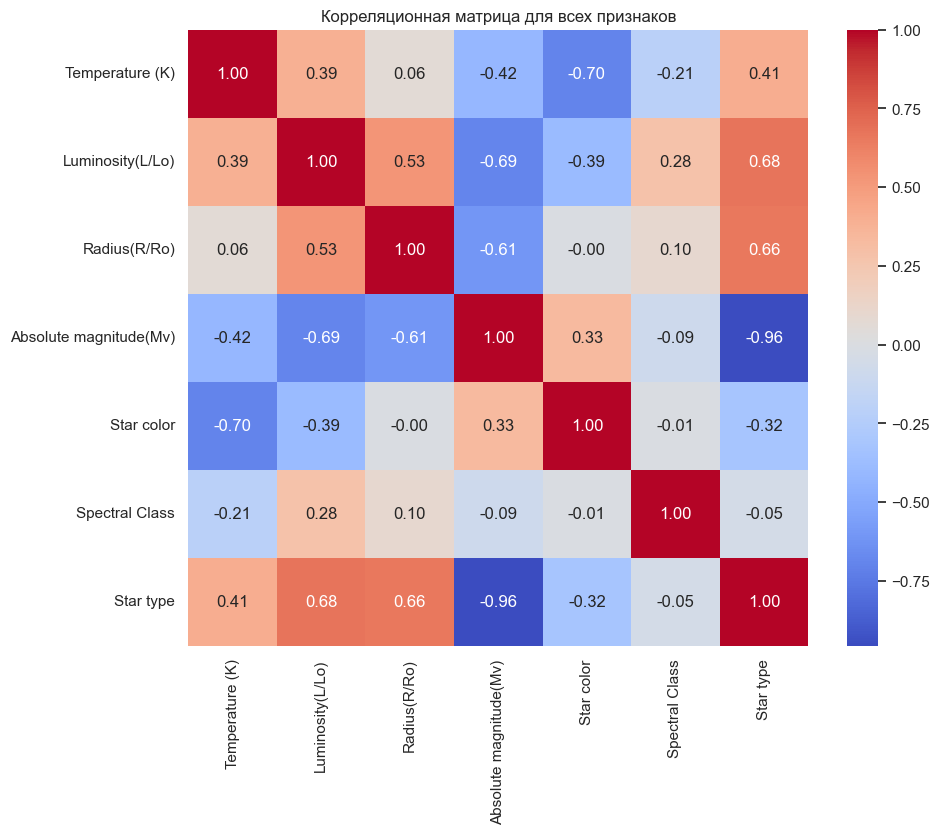

In [11]:
correlation_matrix_all = data_scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_all, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Корреляционная матрица для всех признаков")
plt.show()

На тепловой карте можем отметить, что корреляция между признаками `Star type` и `Absolute magnitude (Mv)` составляет -0.96, что указывает на очень сильную обратную связь между этими признаками. Это может свидетельствовать о том, что оба признака передают схожую информацию. Однако, поскольку наша задача заключается в классификации `Star type`, оба признака мы оставляем, несмотря на высокую корреляцию.

## 4. Реализация методов классификации

### Разделение данных и масштабирование

Разделим данные на тренировочную и тестовую выборки (будем использовать стандартизованные данные, чтобы модели могли корректно обучаться).

In [12]:
from sklearn.model_selection import train_test_split

X = data_scaled.drop(columns=["Star type"])
y = data_scaled["Star type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

display(f"Размеры тренировочных данных: {X_train.shape}")
display(f"Размеры тестовых данных: {X_test.shape}")

'Размеры тренировочных данных: (168, 6)'

'Размеры тестовых данных: (72, 6)'

### Обучение и проверка моделей классификации

Обучим четыре классификационных модели (Логистическую регрессию, RandomForest, SVM и KNN) на тренировочных данных, а затем оценим их точность на тестовых данных. Для каждой модели выведем точность и классификационный отчет, который включает такие метрики, как precision, recall, и f1-score.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  
    accuracy = accuracy_score(y_test, y_pred)  
    results[model_name] = accuracy
    
    display(f"{model_name} Accuracy: {accuracy:.2f}")
    display("Classification Report:")
    display(classification_report(y_test, y_pred, output_dict=False))  

'Logistic Regression Accuracy: 0.94'

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       0.86      1.00      0.92        12\n           1       1.00      0.83      0.91        12\n           2       1.00      1.00      1.00        12\n           3       0.92      0.92      0.92        12\n           4       0.92      0.92      0.92        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           0.94        72\n   macro avg       0.95      0.94      0.94        72\nweighted avg       0.95      0.94      0.94        72\n'

'Random Forest Accuracy: 1.00'

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       1.00      1.00      1.00        12\n           4       1.00      1.00      1.00        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           1.00        72\n   macro avg       1.00      1.00      1.00        72\nweighted avg       1.00      1.00      1.00        72\n'

'SVM Accuracy: 0.96'

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       0.86      1.00      0.92        12\n           1       1.00      0.83      0.91        12\n           2       1.00      1.00      1.00        12\n           3       0.92      1.00      0.96        12\n           4       1.00      0.92      0.96        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           0.96        72\n   macro avg       0.96      0.96      0.96        72\nweighted avg       0.96      0.96      0.96        72\n'

'KNN Accuracy: 0.94'

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       0.92      1.00      0.96        12\n           2       1.00      1.00      1.00        12\n           3       0.85      0.92      0.88        12\n           4       0.91      0.83      0.87        12\n           5       1.00      0.92      0.96        12\n\n    accuracy                           0.94        72\n   macro avg       0.95      0.94      0.94        72\nweighted avg       0.95      0.94      0.94        72\n'

1. **Logistic Regression:**

Точность: 0.94. Это довольно хорошая точность для логистической регрессии, которая, как правило, подходит для линейных зависимостей между признаками и целевой переменной. 

2. **Random Forest:**

Точность: 1.00. Этот результат может свидетельствовать о переобучении модели. Random Forest при небольших и несложных данных может просто запомнить все образцы, не обобщая на новые данные. 

3. **SVM (Support Vector Machine):**

Точность: 0.96. Подобно логистической регрессии, SVM может хорошо работать с данными, если они хорошо разделимы. Высокая точность также указывает на то, что модель хорошо справляется с задачей, но в отличие от RandomForest, SVM не так склонна к переобучению.

4. **KNN (k-Nearest Neighbors):**

Точность: 0.94. Эта модель также показывает довольно хорошую точность, немного ниже двух других, зато без явных свидетельств о переобучении.

На всех моделях получилась очень высокая точность. Это может быть связанно с простотой и не очень большими размерами данных, а также их хорошей предварительной подготовкой, или переобучением моделей. 

Попробуем улучшить качество предсказаний и рассмотреть проблему переобучения.

### Подбор гиперпараметров

Для каждой модели будем задавать диапазон гиперпараметров, который будет исследоваться с помощью GridSearchCV. Он переберет все возможные комбинации гиперпараметров и выберет наилучшие значения для каждого параметра.

In [14]:
from sklearn.model_selection import GridSearchCV

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

param_grid = {
    "Logistic Regression": {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga'], 'max_iter': [1000, 2000]}, 
    "Random Forest": {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]},
    "SVM": {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    "KNN": {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
}

results = {}

for model_name, model in models.items():
    
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[model_name] = accuracy
    
    display(f"{model_name} Accuracy: {accuracy:.2f}")
    display(f"Best parameters: {best_params}")
    display("Classification Report:")
    display(classification_report(y_test, y_pred, output_dict=False))

'Logistic Regression Accuracy: 1.00'

"Best parameters: {'C': 10, 'max_iter': 1000, 'solver': 'saga'}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       1.00      1.00      1.00        12\n           4       1.00      1.00      1.00        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           1.00        72\n   macro avg       1.00      1.00      1.00        72\nweighted avg       1.00      1.00      1.00        72\n'

'Random Forest Accuracy: 1.00'

"Best parameters: {'max_depth': None, 'n_estimators': 100}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       1.00      1.00      1.00        12\n           4       1.00      1.00      1.00        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           1.00        72\n   macro avg       1.00      1.00      1.00        72\nweighted avg       1.00      1.00      1.00        72\n'

'SVM Accuracy: 1.00'

"Best parameters: {'C': 10, 'kernel': 'linear'}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       1.00      1.00      1.00        12\n           4       1.00      1.00      1.00        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           1.00        72\n   macro avg       1.00      1.00      1.00        72\nweighted avg       1.00      1.00      1.00        72\n'

'KNN Accuracy: 0.97'

"Best parameters: {'n_neighbors': 3, 'weights': 'distance'}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       0.92      1.00      0.96        12\n           4       0.92      0.92      0.92        12\n           5       1.00      0.92      0.96        12\n\n    accuracy                           0.97        72\n   macro avg       0.97      0.97      0.97        72\nweighted avg       0.97      0.97      0.97        72\n'

После проведения поиска гиперпараметров и оценки моделей были получены следующие результаты:

- Logistic Regression: Точность (Accuracy): 1.00
- Random Forest: Точность (Accuracy): 1.00
- SVM: Точность (Accuracy): 1.00
- KNN: Точность (Accuracy): 0.97

Удалось улучшить качество предсказаний, однако большинство моделей показали Accuracy = 1.00. Такие результаты могут быть связаны с: простотой данных (вероятно, классы хорошо разделяются), отсутствием шума в данных, но и возможным переобучением на небольшом наборе данных. Проверим это с помощью кросс-валидации.

### Применение кросс-валидации

In [15]:
from sklearn.model_selection import cross_val_score

for model_name, model in models.items():
    
    # Для логистической регрессии задаю solver и max_iter, так как иначе были предупреждения о несходимости модели.
    if model_name == "Logistic Regression":
        model = LogisticRegression(solver='saga', max_iter=1000)
    
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
    display(f"Cross-validated accuracy for {model_name}: {cv_scores.mean():.2f}")
    
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results[model_name] = accuracy
    
    display(f"{model_name} Accuracy: {accuracy:.2f}")
    display(f"Best parameters: {best_params}")
    display("Classification Report:")
    display(classification_report(y_test, y_pred, output_dict=False))

'Cross-validated accuracy for Logistic Regression: 0.97'

'Logistic Regression Accuracy: 1.00'

"Best parameters: {'C': 10, 'max_iter': 1000, 'solver': 'saga'}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       1.00      1.00      1.00        12\n           4       1.00      1.00      1.00        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           1.00        72\n   macro avg       1.00      1.00      1.00        72\nweighted avg       1.00      1.00      1.00        72\n'

'Cross-validated accuracy for Random Forest: 0.99'

'Random Forest Accuracy: 1.00'

"Best parameters: {'max_depth': 20, 'n_estimators': 50}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       1.00      1.00      1.00        12\n           4       1.00      1.00      1.00        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           1.00        72\n   macro avg       1.00      1.00      1.00        72\nweighted avg       1.00      1.00      1.00        72\n'

'Cross-validated accuracy for SVM: 0.98'

'SVM Accuracy: 1.00'

"Best parameters: {'C': 10, 'kernel': 'linear'}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       1.00      1.00      1.00        12\n           4       1.00      1.00      1.00        12\n           5       1.00      1.00      1.00        12\n\n    accuracy                           1.00        72\n   macro avg       1.00      1.00      1.00        72\nweighted avg       1.00      1.00      1.00        72\n'

'Cross-validated accuracy for KNN: 0.98'

'KNN Accuracy: 0.97'

"Best parameters: {'n_neighbors': 3, 'weights': 'distance'}"

'Classification Report:'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        12\n           1       1.00      1.00      1.00        12\n           2       1.00      1.00      1.00        12\n           3       0.92      1.00      0.96        12\n           4       0.92      0.92      0.92        12\n           5       1.00      0.92      0.96        12\n\n    accuracy                           0.97        72\n   macro avg       0.97      0.97      0.97        72\nweighted avg       0.97      0.97      0.97        72\n'

После применения кросс-валидации и финальной оценки моделей были получены следующие результаты:
1. **Logistic Regression**:
- Cross-validated accuracy: 0.97
- Точность (Accuracy): 1.00
2. **Random Forest**
- Cross-validated accuracy: 0.99
- Точность (Accuracy): 1.00
3. **SVM**
- Cross-validated accuracy: 0.98
- Точность (Accuracy): 1.00
4. **KNN**
- Cross-validated accuracy: 0.98
- Точность (Accuracy): 0.97

Кросс-валидация показала, что модели действительно имеют высокую обобщающую способность (все cv_scores > 0.97), результаты не сильно ниже, чем на тестовом наборе, что не является показателем переобучения. Возможно, высокие результаты связаны с тем, что данные слишком просты для разделения, а тестовый набор совпадает по структуре с тренировочным.

Попробуем протестировать влияние изменения пропорции разбиения данных на результаты моделей. Будем использовать новое разбиение, например 50/50, и сравним результаты с предыдущими.

In [16]:
from sklearn.model_selection import train_test_split

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

results_new_split = {}

for model_name, model in models.items():
    model.fit(X_train_new, y_train_new)
    
    y_pred_new = model.predict(X_test_new)
    
    accuracy_new = accuracy_score(y_test_new, y_pred_new)
    results_new_split[model_name] = accuracy_new
    
    cv_scores_new = cross_val_score(model, X_train_new, y_train_new, cv=5, scoring='accuracy')
    
    display(f"Cross-validated accuracy for {model_name} (50/50 split): {cv_scores_new.mean():.2f}")
    display(f"{model_name} Accuracy (50/50 split): {accuracy_new:.2f}")
    display("Classification Report (50/50 split):")
    display(classification_report(y_test_new, y_pred_new, output_dict=False))

'Cross-validated accuracy for Logistic Regression (50/50 split): 0.95'

'Logistic Regression Accuracy (50/50 split): 0.97'

'Classification Report (50/50 split):'

'              precision    recall  f1-score   support\n\n           0       0.87      1.00      0.93        20\n           1       1.00      0.85      0.92        20\n           2       1.00      1.00      1.00        20\n           3       0.95      1.00      0.98        20\n           4       1.00      0.95      0.97        20\n           5       1.00      1.00      1.00        20\n\n    accuracy                           0.97       120\n   macro avg       0.97      0.97      0.97       120\nweighted avg       0.97      0.97      0.97       120\n'

'Cross-validated accuracy for Random Forest (50/50 split): 0.99'

'Random Forest Accuracy (50/50 split): 0.99'

'Classification Report (50/50 split):'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        20\n           1       0.95      1.00      0.98        20\n           2       1.00      1.00      1.00        20\n           3       1.00      0.95      0.97        20\n           4       1.00      1.00      1.00        20\n           5       1.00      1.00      1.00        20\n\n    accuracy                           0.99       120\n   macro avg       0.99      0.99      0.99       120\nweighted avg       0.99      0.99      0.99       120\n'

'Cross-validated accuracy for SVM (50/50 split): 0.96'

'SVM Accuracy (50/50 split): 0.99'

'Classification Report (50/50 split):'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        20\n           1       1.00      1.00      1.00        20\n           2       1.00      1.00      1.00        20\n           3       0.95      1.00      0.98        20\n           4       1.00      0.95      0.97        20\n           5       1.00      1.00      1.00        20\n\n    accuracy                           0.99       120\n   macro avg       0.99      0.99      0.99       120\nweighted avg       0.99      0.99      0.99       120\n'

'Cross-validated accuracy for KNN (50/50 split): 0.93'

'KNN Accuracy (50/50 split): 0.97'

'Classification Report (50/50 split):'

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00        20\n           1       0.95      1.00      0.98        20\n           2       1.00      1.00      1.00        20\n           3       0.90      0.95      0.93        20\n           4       0.95      0.90      0.92        20\n           5       1.00      0.95      0.97        20\n\n    accuracy                           0.97       120\n   macro avg       0.97      0.97      0.97       120\nweighted avg       0.97      0.97      0.97       120\n'

Даже на новом разбиении, где доступно больше данных для тестирования, модели сохраняют высокую точность.
Кросс-валидация на тренировочной выборке показывает схожие результаты, что указывает на то, что модели не запоминают данные, а находят обобщённые закономерности. Можем сделать вывод, что переобучения нет. Модели демонстрируют хорошую способность к обобщению, что связано с тем, что: данные имеют простую для разделения структуру; используемые алгоритмы достаточно мощные для этой задачи.

### Confusion matrices

Для детального анализа качества классификации каждой модели построим матрицы ошибок (confusion matrices). Они позволяют визуально оценить, какие классы модели путают, и выявить слабые стороны в их работе. Это поможет сравнить модели не только по общим метрикам, но и понять, где именно происходят ошибки.

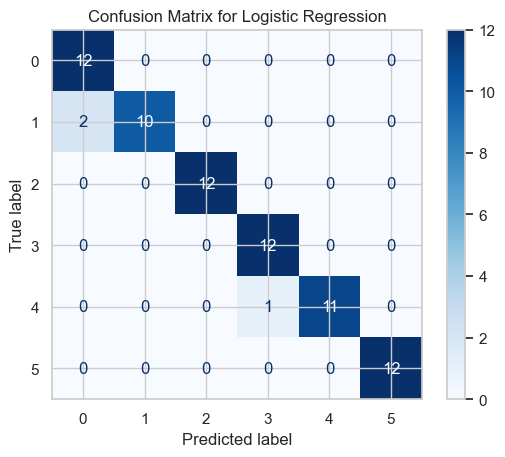

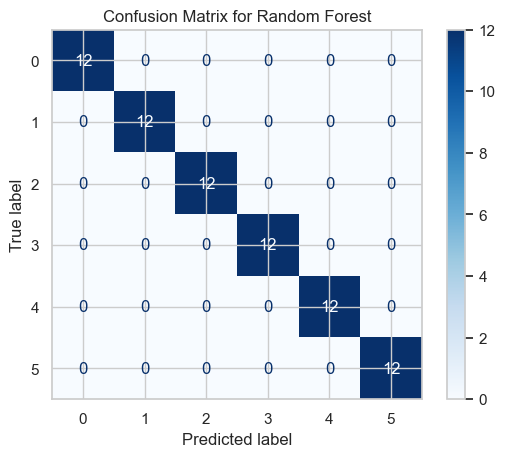

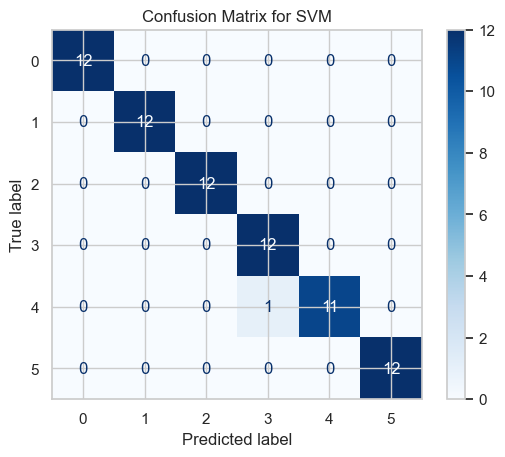

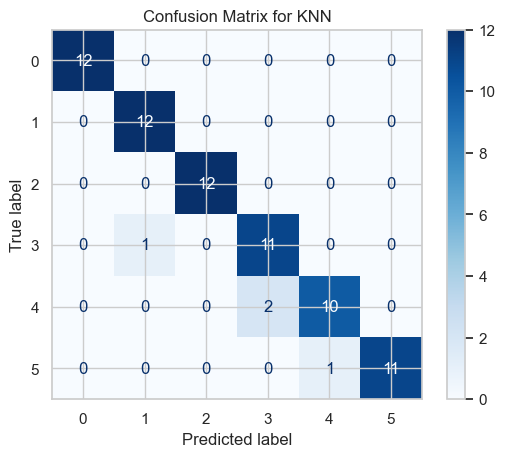

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(y_true))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

for model_name, model in models.items():  
    y_pred = model.predict(X_test)  
    plot_confusion_matrix(y_test, y_pred, model_name)

- Random Forest идеально классифицирует все объекты — наиболее точная модель на этом наборе данных.
- SVM допускает минимальные ошибки (одна в четвёртом классе), что тоже говорит о высоком уровне производительности.
- Logistic Regression также работает хорошо, но заметны ошибки в первом и четвёртом классах.
- KNN показывает больше ошибок по сравнению с другими моделями.

## 5. Итоговый вывод о сравнении моделей и их работе на выбранных данных

В рамках задачи классификации на данном наборе данных было обучено и протестировано четыре модели: Logistic Regression, Random Forest, SVM и KNN.

1. Метрики точности и кросс-валидации:
- На этапе оценки моделей с использованием кросс-валидации все модели показали высокие результаты (более 97% точности), что свидетельствует об их способности обобщать знания.
- На тестовой выборке точность Random Forest, SVM и Logistic Regression составила почти 100%, а KNN показал несколько более низкий результат (97%).
- Различие между результатами кросс-валидации и тестовой выборки минимально, что указывает на отсутствие значительного переобучения.

2. Анализ матриц ошибок:
- Random Forest: полностью исключила ошибки, что делает её лучшим выбором для данного набора данных.
- SVM: допустила одну ошибку, но в остальном классифицировала объекты практически идеально.
- Logistic Regression: показала хорошие результаты, однако были замечены некоторые ошибки.
- KNN: продемонстрировала больше ошибок по сравнению с другими моделями, что свидетельствует о её меньшей устойчивости в данной задаче.

**Выводы о данных и задаче:**

Данные являются сравнительно простыми для классификации, что подтверждается высокими результатами всех моделей. Однако наличие небольшого количества ошибок в Logistic Regression, SVM и KNN может указывать на то, что классы частично пересекаются или недостаточно выражены в пространстве признаков. Для решения задачи классификации на данном наборе данных оптимальным выбором является Random Forest, так как она полностью исключает ошибки и демонстрирует высокую стабильность. 

## 6. Самостоятельная реализация одного из методов классификации с возможностью настройки гиперпараметров.

Будем реализовывать **метод k ближайших соседей (k-Nearest Neighbors, kNN)**, так как он понятен и не требует сложной математической оптимизации. Алгоритм также позволяет гибко настроить два основных гиперпараметра: число соседей и метрику расстояния. Он основывается на сравнении нового объекта с уже известными образцами. Алгоритм определяет класс объекта на основе меток его ближайших k соседей в пространстве признаков, используя заданную метрику расстояния (например, евклидову или манхэттенскую).

1. Реализуем класс KNN_model, который принимает два параметра: n_neighbors — число ближайших соседей k, metric — метрика для расчёта расстояния (euclidean или manhattan).
2. Метод fit сохраняет обучающую выборку.
3. Метод _calculate_distance вычисляет расстояние между двумя объектами в зависимости от выбранной метрики.
4. Метод predict классифицирует новые объекты, находя их ближайших соседей и выбирая наиболее часто встречающийся класс.
5. Функция cross_validate_knn выполняет кросс-валидацию, находит лучшие гиперпараметры (k и метрику) и возвращает их вместе с наилучшей точностью.

In [21]:
import numpy as np
from sklearn.model_selection import KFold

class KNN_model:
    def __init__(self, n_neighbors=3, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _calculate_distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))

    def predict(self, X):
        predictions = []
        for x in X:
            distances = [self._calculate_distance(x, x_train) for x_train in self.X_train]
            neighbor_indices = np.argsort(distances)[:self.n_neighbors]
            neighbor_labels = self.y_train[neighbor_indices]
            predicted_label = np.argmax(np.bincount(neighbor_labels))
            predictions.append(predicted_label)
        return np.array(predictions)

def cross_validate_knn(X, y, n_neighbors_list, metric_list, cv=5):
    best_score = 0
    best_params = {}
    for n_neighbors in n_neighbors_list:
        for metric in metric_list:
            model = KNN_model(n_neighbors=n_neighbors, metric=metric)
            scores = []
            kf = KFold(n_splits=cv)
            for train_index, val_index in kf.split(X):
                X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
                y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
                model.fit(X_train_cv.values, y_train_cv.values)  
                y_pred_cv = model.predict(X_val_cv.values)  
                scores.append(accuracy_score(y_val_cv, y_pred_cv))
            avg_score = np.mean(scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = {'n_neighbors': n_neighbors, 'metric': metric}
    return best_params, best_score

params, score = cross_validate_knn(X_train, y_train, n_neighbors_list=[3, 5, 7], metric_list=['euclidean', 'manhattan'])
print(f"Лучшие параметры: {params}, точность: {score:.2f}")

Лучшие параметры: {'n_neighbors': 3, 'metric': 'manhattan'}, точность: 0.96


Получили точность 96%. Данный результат демонстрирует, что модель KNN с указанными параметрами способна эффективно классифицировать данные.

### Confusion matrix

Построим матрицу ошибок (confusion matrix) для оценки качества предсказаний модели, реализованной вручную. 

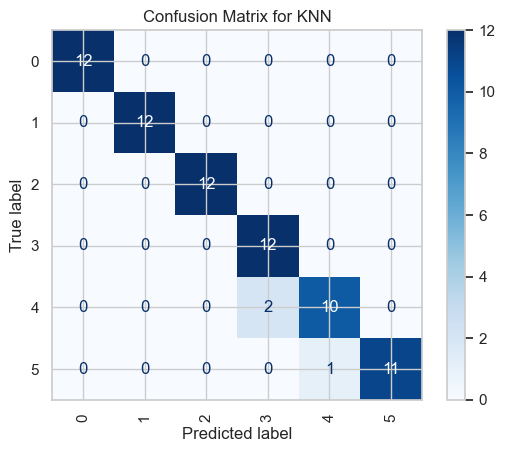

In [22]:
best_knn = KNN_model(n_neighbors=params['n_neighbors'], metric=params['metric'])
best_knn.fit(X_train.values, y_train.values)

y_test_pred = best_knn.predict(X_test.values)

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title(f'Confusion Matrix for KNN')
plt.show()

Модель показала хорошие результаты, большинство объектов классифицировано правильно. Ошибки замечены в 4 и 5 классах (2 и 1 ошибка соответственно).

### Сравнение моделей

Библиотечная реализация KNN показала такие результаты: Cross-validated accuracy: 0.98; Точность (Accuracy): 0.97. В confusion matrix были небольшие ошибки в 3, 4 и 5 классах. Самостоятельно реализованная модель KNN показала точность 0.96, в confusion matrix небольшие ошибки в 4 и 5 классах. Общая тенденция ошибок близка к библиотечной реализации, однако количество неверных классификаций оказалось немного меньше (библиотечная KNN могла лучше классифицировать более частые классы, что улучшило её общую точность, несмотря на наличие одной дополнительной ошибки). 

Таким образом, самостоятельная модель KNN показала результаты, сопоставимые с библиотечной KNN, уступая в точности примерно на 1%. 

## 7. Итоги задачи

Данный набор данных является сравнительно простым для классификации, о чём свидетельствуют высокие результаты всех моделей. Самостоятельная реализация KNN продемонстрировала сопоставимые результаты с библиотечным вариантом, что подтверждает правильность выбранного подхода и пригодность метода. Однако для более сложных задач использование библиотечных реализаций предпочтительнее благодаря их оптимизации, скорости работы и поддержке расширенного функционала.

Наилучший результат для решения задачи классификации на данных данного типа продемонстрировал Random Forest.